In [19]:
#%%writefile rematch_df.py
import pandas as pd
import numpy as np
import scipy as sp
import scipy.stats as stats
import matplotlib.pyplot as plt

plt.style.use('ggplot')


import build_financial_df as fin
import build_results_df as res
import merge_df as mer

# get top 2 candidates from each race, leaving 13212 candidates total
# this step simplifies, but reduces info about third party candidates
top2_cand = mer.merge_df_cut.groupby('elec_id')['vote%'].nlargest(2)
# top2_cand is a pd.Series double-indexed by new_elec_id & merge_df_cut index no.


# make dictionary with values equal to set of names of top 2 candidates 
cand_pair_dct = {}
for pair in top2_cand.index:
    l_name = mer.merge_df_cut.loc[pair[1], 'last_name']
    if pair[0] not in cand_pair_dct:
        cand_pair_dct[pair[0]] = set()
    cand_pair_dct[pair[0]].add(l_name)

# list of sets of rematch races
from itertools import chain
rev_dict = {}
for key, value in cand_pair_dct.items():
    rev_dict.setdefault(str(value), set()).add(key)
rematch_list = [values for key, values in rev_dict.items() if len(values) > 1]

rematch_elec_id = []
for i in rematch_list:
    for x in i:
        rematch_elec_id.append(x)
        
# create dataframe of the 13212 'candidate entries' (bear in mind each candidate is in there at least twice)
index_list = [top2_cand.index[i][1] for i in range(len(top2_cand))]
rematch_df_start = mer.merge_df_start[mer.merge_df_start['elec_id'].isin(rematch_elec_id)]

'''

#use this to see how many races remain in dataset; this should be 
count_ttl = 0
for each in rematch_list:
    x = len(each)
    count_ttl += x
count_ttl
# first attempt, count_ttl is 1324
# second attempt, count_ttl is 1295... this makes sense because 

'''

rematch_cut = rematch_df_start[['FEC_ID','elec_id','year', 'candidate', 'candidatevotes', 'vote%', 'office', 'party', 'state', 'district','INC_STATUS','totalvotes', 'TTL_RECEIPTS', 'TTL_DISB']]

rematch3 = rematch_cut[(~rematch_cut['delta_spend'].isna()) & (~rematch_cut['delta_vote'].isna())]
rematch4 = rematch3[rematch3['delta_vote']!= 0]
rematch4
#I expected 1374; I got 1208 entries 
# missing 166

for i in range(len(rematch_list)):
    a = rematch_cut[rematch_cut['elec_id']==list(rematch_list[i])[0]].sort_values('FEC_ID').reset_index()
    b = rematch_cut[rematch_cut['elec_id']==list(rematch_list[i])[1]].sort_values('FEC_ID').reset_index()
    i1 = a['index'][0]
    i2 = a['index'][1]
    i3 = b['index'][0]
    i4 = b['index'][1]
    a.set_index('candidate')
    b.set_index('candidate')
    #print(a)
    #print(i1, i2, i3, i4)
    
    x = b['vote%']-a['vote%']
    # delta_vote for cand-idx0 in election a
    rematch_cut.loc[i1, 'delta_vote'] = 0
    # delta_vote for cand-idx1 in election a
    rematch_cut.loc[i2, 'delta_vote'] = 0
    # delta_vote for cand-idx0 in election b
    rematch_cut.loc[i3, 'delta_vote'] = x[0]
    # delta_vote for cand-idx1 in election b
    rematch_cut.loc[i4, 'delta_vote'] = x[1] 
    #print(x)
    y = b['TTL_DISB']-a['TTL_DISB']
    # delta_spend for cand-idx0 in election a
    rematch_cut.loc[i1, 'delta_spend'] = 0
    # delta_spend for cand-idx1 in election a
    rematch_cut.loc[i2, 'delta_spend'] = 0
    # delta_spend for cand-idx0 in election b
    rematch_cut.loc[i3, 'delta_spend'] = y[0]
    # delta_spend for cand-idx1 in election b
    rematch_cut.loc[i4, 'delta_spend'] = y[1] 
    #print(y)
    
rematch3 = rematch_cut[(~rematch_cut['delta_spend'].isna()) & (~rematch_cut['delta_vote'].isna())]
rematch4 = rematch3[rematch3['delta_vote']!= 0]
rematch4
#I expected 1374; I got 1208 entries 
# missing 166

Overwriting rematch_df.py


In [55]:
def get_rematch_table(idx):
    cand_rematch = mer.merge_df_cut[mer.merge_df_cut.loc[:, 'elec_id'].isin(rematch_list[idx])]
    return cand_rematch[['FEC_ID','elec_id','year', 'candidate', 'candidatevotes', 'office', 'party', 'state', 
                         'district','INC_STATUS','totalvotes', 'TTL_RECEIPTS', 'TTL_DISB']]

get_rematch_table(88)

,FEC_ID,elec_id,year,candidate,candidatevotes,office,party,state,district,INC_STATUS,totalvotes,TTL_RECEIPTS,TTL_DISB
3839,H0CA11022,1986-CA-11,1986,Tom Lantos,112380,US House,democrat,California,11,I,151695,299231.0,325435.0
3840,H6CA11011,1986-CA-11,1986,"G. M. ""Bill"" Quraishi",39315,US House,republican,California,11,NaN,151695,69374.0,63996.0
4562,H0CA11022,1988-CA-11,1988,Tom Lantos,145484,US House,democrat,California,11,I,205016,386453.0,269510.0
4563,H6CA11011,1988-CA-11,1988,"G. M. ""Bill"" Quraishi",50050,US House,republican,California,11,NaN,205016,90306.0,95575.0
5281,H6CA11011,1990-CA-11,1990,Bill Quraishi,45818,US House,republican,California,11,NaN,159365,97638.0,97030.0
5282,H0CA11022,1990-CA-11,1990,Tom Lantos,105029,US House,democrat,California,11,I,159365,788298.0,646730.0


In [ ]:

'''
# eventually want to check (and filter out) for weirdos where total vote % > 100%
sum_vote_percent = merge_df_cut.groupby('new_elec_id')['vote%'].nlargest(2).sum(level=0)
# below attempt didn't work
sum_percent_df = pd.DataFrame()
sum_percent_df = sum_vote_percent[sum_vote_percent<=100]
merge_df_cut2 = merge_df_cut[merge_df_cut['new_elec_id'].isin(sum_percent_df.reset_index()['index'])]
merge_df_cut2
'''



In [8]:
rematch3 = rematch_cut[(~rematch_cut['delta_spend'].isna()) & (~rematch_cut['delta_vote'].isna())]
rematch4 = rematch3[rematch3['delta_vote']!= 0]
rematch4
#I expected 1374; I got 1208 entries 
# missing 166

,FEC_ID,elec_id,year,candidate,candidatevotes,vote%,office,party,state,district,INC_STATUS,totalvotes,TTL_RECEIPTS,TTL_DISB,delta_vote,delta_spend
402,S8MN00024,1990-MN-SE,1990,Rudy Boschwitz,864375,47.81,US Senate,republican,Minnesota,statewide,I,1808045,6087588.00,6222333.00,40.83,6177669.00
403,S0MN00013,1990-MN-SE,1990,Paul David Wellstone,911999,50.44,US Senate,democrat,Minnesota,statewide,C,1808045,1401706.00,1380560.00,0.12,-4598664.00
533,S0HI00084,1994-HI-SE,1994,Daniel K. Akaka,256189,71.78,US Senate,democrat,Hawaii,statewide,I,356902,622945.00,421356.00,-4.27,310866.00
534,S8HI00012,1994-HI-SE,1994,Maria M. Hustace,86320,24.19,US Senate,republican,Hawaii,statewide,C,356902,29815.00,30272.00,2.47,-2067.00
662,S8NC00015,1996-NC-SE,1996,Jesse Helms,1345833,52.64,US Senate,republican,North Carolina,statewide,I,2556456,7808820.00,7796475.00,0.10,-5628646.00
663,S0NC00111,1996-NC-SE,1996,Harvey B. Gantt,1173875,45.92,US Senate,democrat,North Carolina,statewide,NaN,2556456,8122834.00,8007266.00,-1.51,198796.00
723,S6MD00140,1998-MD-SE,1998,Barbara A. Mikulski,1062810,70.50,US Senate,democrat,Maryland,statewide,I,1507447,2908352.00,3014312.00,69.18,3013996.00
724,S8MD00179,1998-MD-SE,1998,Ross Z. Pierpont,444637,29.50,US Senate,republican,Maryland,statewide,C,1507447,297770.00,297768.00,-0.97,184042.00
757,S2VT00110,1998-VT-SE,1998,Hugh Douglas,4199,1.96,US Senate,libertarian,Vermont,statewide,NaN,214036,50.00,0.00,-41.39,-195737.00
758,S4VT00017,1998-VT-SE,1998,Patrick J. Leahy,154567,72.22,US Senate,democrat,Vermont,statewide,I,214036,1148594.00,1009724.00,18.06,17893.00


Text(0, 0.5, 'Change in Vote Point')

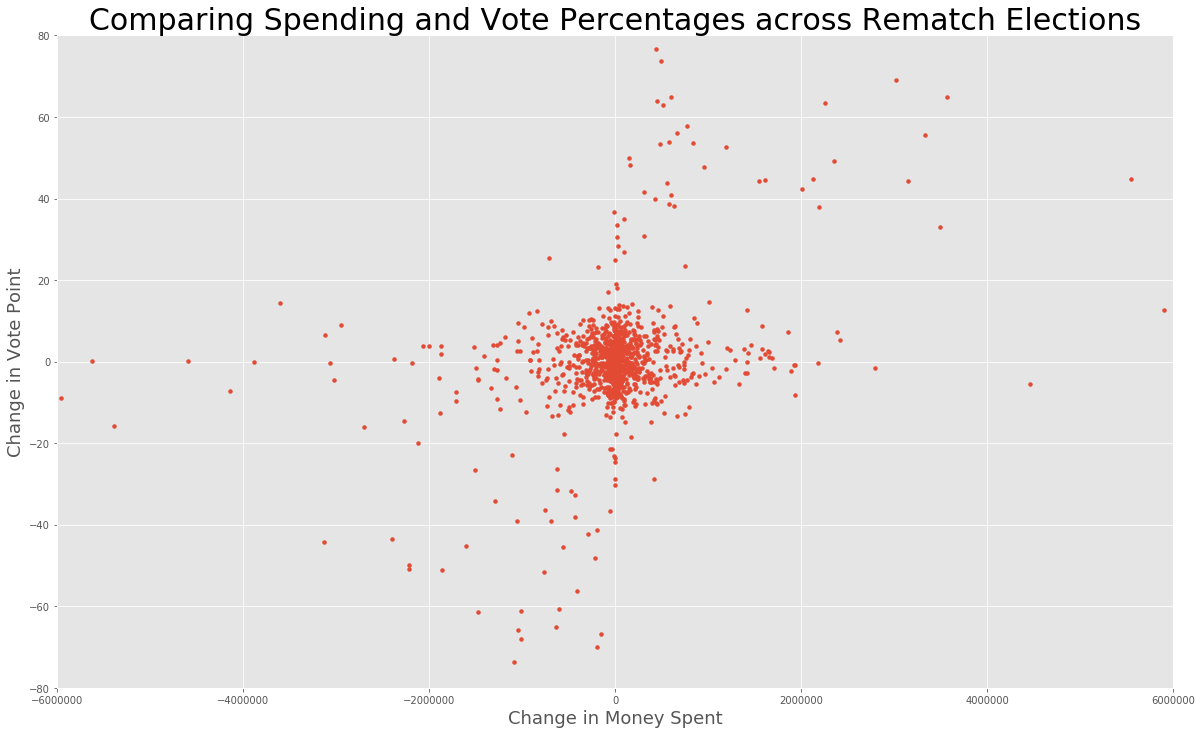

In [18]:
plot_all = rematch4[['delta_vote', 'delta_spend']]
x = plot_all['delta_vote']
y = plot_all['delta_spend']
fig, ax = plt.subplots(1, figsize=(20,12))
ax.scatter(y, x, alpha=1, s=15)
ax.set_xlim(-6000000, 6000000)
ax.set_ylim(-80, 80)
ax.set_title('Comparing Spending and Vote Percentages across Rematch Elections', fontsize=30)
ax.set_xlabel('Change in Money Spent', fontsize=18)
ax.set_ylabel('Change in Vote Point', fontsize=18)

In [9]:
rematch_GOP = rematch4[rematch4['party']=='republican']
rematch_Dem = rematch4[rematch4['party']=='democrat']
rematch_Ind = rematch4[(rematch4['party']!='democrat') & (rematch3['party']!='republican')]

Text(0, 0.5, 'Change in Vote Point')

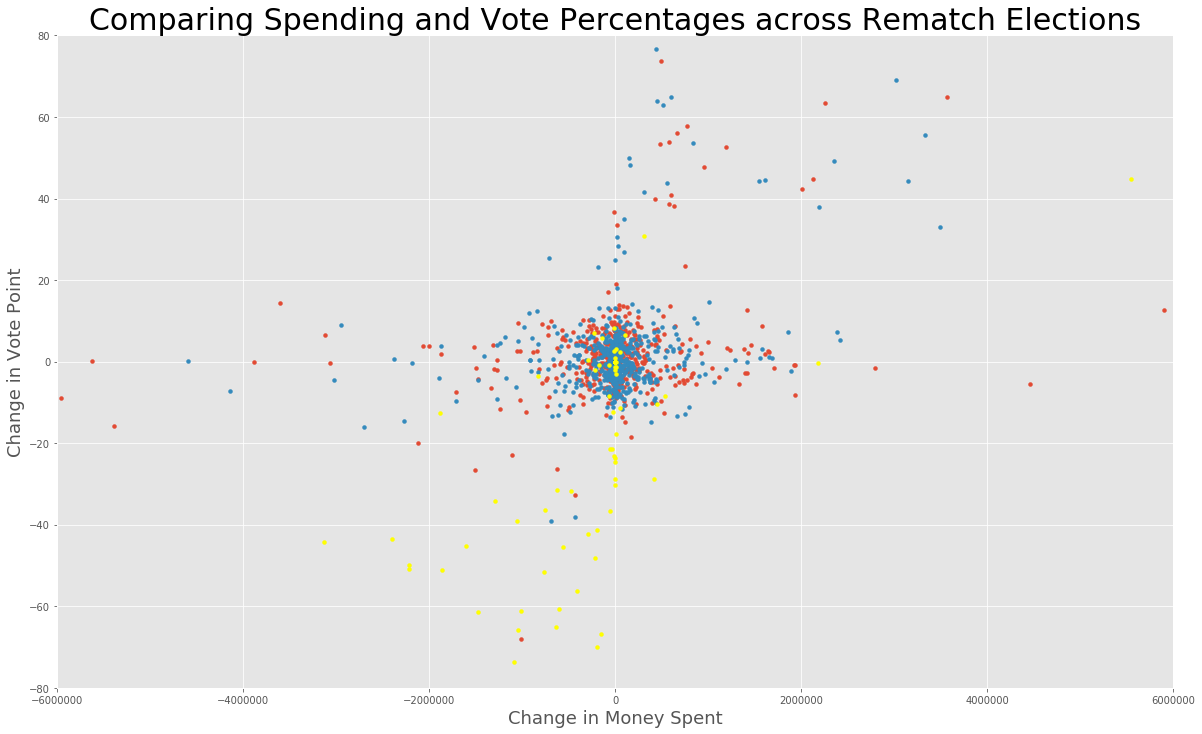

In [17]:
plot_GOP = rematch_GOP[['delta_vote', 'delta_spend']]
plot_Dem = rematch_Dem[['delta_vote', 'delta_spend']]
plot_Ind = rematch_Ind[['delta_vote', 'delta_spend']]

x = plot_GOP['delta_vote']
y = plot_GOP['delta_spend']
w = plot_Dem['delta_vote']
z = plot_Dem['delta_spend']
t = plot_Ind['delta_vote']
u = plot_Ind['delta_spend']

fig, ax = plt.subplots(1, figsize=(20,12))
ax.scatter(y, x, alpha=1, s=15)
ax.scatter(z, w, alpha=1, s=15)
ax.scatter(u, t, color='yellow', alpha=1, s=15)

ax.set_xlim(-6000000, 6000000)
ax.set_ylim(-80, 80)
ax.set_title('Comparing Spending and Vote Percentages across Rematch Elections', fontsize=30)
ax.set_xlabel('Change in Money Spent', fontsize=18)
ax.set_ylabel('Change in Vote Point', fontsize=18)

